In [11]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas_datareader as web
import math
import yfinance as yf
import pandas as pd
import seaborn as sns

# Lecture des informations finance depuis Yahoo

In [12]:
etf = ['BZ=F','EURUSD=X','TTF=F','TTFX23.NYM','TTFZ23.NYM','TTFU23.NYM','TTFV23.NYM']
#data = yf.Ticker(etf)
#dataH = data.history(start='2007-01-01',period='1d')
it = yf.download(tickers=etf, period='1d',start='2012-01-01')
it = it.rename(columns = {'TTFU23.NYM':'SEP23', 'TTFX23.NYM':'NOV23','TTFV23.NYM':'OCT23', 'TTFZ23.NYM':'DEC23', 'EURUSD=X':'€/$'})

[*********************100%***********************]  7 of 7 completed


# Lecture des informations de stock de Gaz depuis AGSI
* normalisation des données
* conversion en float
* conversion des dates

pour un Pays remplacer "type" par "country" et mettre en paramètre le code du pays : FR, BE, DE ...

In [13]:
import requests
params = {
    "type": "EU",
    "from": "2012-01-01",
    "size": 10000
}
header = {
  "x-key" : "99e18f932d22c9acf9c42f27d0b8b539" }

url = "https://agsi.gie.eu/api"
resp = requests.get(url=url, params=params, headers=header)
json = resp.json()
data = pd.json_normalize(json['data'])
data["gasInStorage"] = data["gasInStorage"].astype(float)
#data["coveredCapacity"] = data["coveredCapacity"].astype(float)
pd.to_datetime(data['gasDayStart'], errors='coerce')
#data[["gasDayStart","gasInStorage"]]
#print(data)
print('Done')

Done


### Préparation des données (en mois / années)

In [14]:
import datetime as dt
endData = data[["gasDayStart","gasInStorage"]].copy(deep = True)
endData['Date'] = pd.to_datetime(endData['gasDayStart'],format='%Y-%m-%d', errors='coerce',utc=False)
endData['année'] = endData['Date'].dt.year
endData['mois'] = endData['Date'].dt.month
endData.set_index('Date')

,gasDayStart,gasInStorage,année,mois
Date,,,,
2023-08-16,2023-08-16,1024.0480,2023,8
2023-08-15,2023-08-15,1021.2330,2023,8
2023-08-14,2023-08-14,1018.0052,2023,8
2023-08-13,2023-08-13,1014.4931,2023,8
2023-08-12,2023-08-12,1010.3931,2023,8
...,...,...,...,...
2012-01-05,2012-01-05,547.8834,2012,1
2012-01-04,2012-01-04,550.0136,2012,1
2012-01-03,2012-01-03,552.2452,2012,1


In [15]:
def filtreAnnee(df, a):
    mask_ = (df['année'] == a)
    #mask_ = ((fin['mois'] == 2) & (fin['year'] == 2022))
    return df.loc[mask_]

              gasInStorage     TTF=F      BZ=F     SEP23     OCT23     NOV23  \
gasInStorage      1.000000 -0.079695  0.174310 -0.114701 -0.097561 -0.014052   
TTF=F            -0.079695  1.000000  0.424423  0.995374  0.992386  0.966001   
BZ=F              0.174310  0.424423  1.000000  0.386010  0.391995  0.379357   
SEP23            -0.114701  0.995374  0.386010  1.000000  0.998049  0.974520   
OCT23            -0.097561  0.992386  0.391995  0.998049  1.000000  0.985352   
NOV23            -0.014052  0.966001  0.379357  0.974520  0.985352  1.000000   
DEC23             0.073457  0.937774  0.385711  0.945386  0.960755  0.992846   

                 DEC23  
gasInStorage  0.073457  
TTF=F         0.937774  
BZ=F          0.385711  
SEP23         0.945386  
OCT23         0.960755  
NOV23         0.992846  
DEC23         1.000000  


<AxesSubplot:>

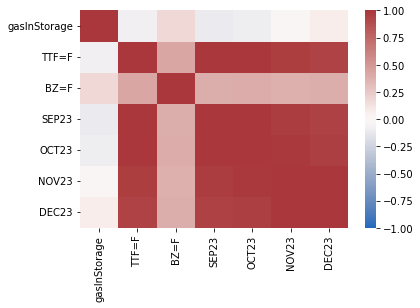

In [16]:
final = pd.merge(endData, it['Close'], how='left', on="Date" )
fin =final.dropna()
# mask_ = (fin['année'] == 2023)
# #mask_ = ((fin['mois'] == 2) & (fin['year'] == 2022))
# fin_ = fin.loc[mask_]
fin_ = filtreAnnee(fin, 2023)
fin_ = (fin_[["gasInStorage","TTF=F","BZ=F","SEP23","OCT23","NOV23","DEC23","Date"]])
fin_ = fin_.set_index("Date")
print(fin_.corr())
sns.heatmap(fin_.corr(),cmap='vlag', vmin=-1, vmax=1)

Stock maxi sur la période :  1024.048


<AxesSubplot:xlabel='Date'>

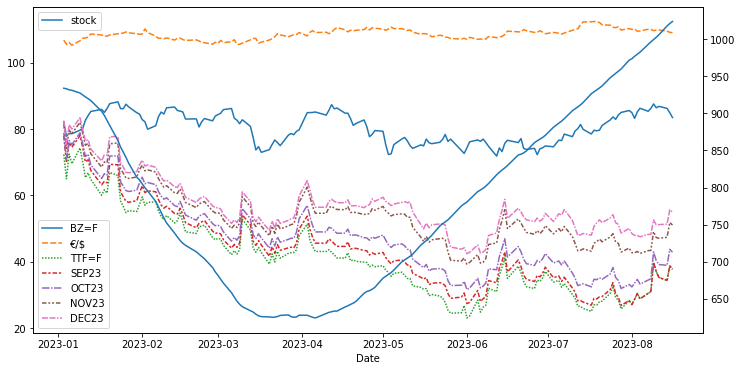

In [17]:
# On fait une copie du DF et on remet les index
# cette copy est filtrée suivant l'année
an = 2023
fin_1 = filtreAnnee(fin,an).copy(deep=True)
fin_2 = filtreAnnee(fin[['gasInStorage','Date','année']],an).copy(deep=True)
fin_1 = fin_1.set_index("Date")
fin_2 = fin_2.set_index("Date")
# On normalise si besoin 
maxi = fin_1["gasInStorage"].max()
print('Stock maxi sur la période : ',maxi)
maxi = 100.0 # si on ne souhaite pas normaliser
# on normalise le stock (100%) et on nettoye ...
fin_2["stock"] = fin_2["gasInStorage"] / maxi * 100.0
# print(fin_1.head())
fin_1['€/$'] = fin_1['€/$'] * 100.0
fin_1 = fin_1.drop(['année','mois','gasDayStart','gasInStorage'], axis=1)
fin_2 = fin_2.drop(['gasInStorage','année'],axis=1)
# on Affiche le graphique
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=fin_1, color='Blue')
ax2 = plt.twinx()
sns.lineplot(data=fin_2, ax=ax2 , color='red')

In [27]:
fin[0:16]

,gasDayStart,gasInStorage,Date,année,mois,BZ=F,€/$,TTF=F,SEP23,OCT23,NOV23,DEC23
0,2023-08-16,1024.0480,2023-08-16,2023,8,83.449997,1.090417,37.784000,37.784000,42.896000,51.080002,54.980000
1,2023-08-15,1021.2330,2023-08-15,2023,8,84.889999,1.090988,38.813000,38.813000,43.785000,51.865002,55.710999
2,2023-08-14,1018.0052,2023-08-14,2023,8,86.209999,1.094439,34.433998,34.433998,38.959999,47.386002,51.355000
5,2023-08-11,1006.1800,2023-08-11,2023,8,86.809998,1.098165,35.299999,35.299999,39.194000,47.111000,51.215000
6,2023-08-10,1002.6741,2023-08-10,2023,8,86.400002,1.097767,37.056000,37.056000,40.340000,47.292999,51.162998
7,2023-08-09,999.6377,2023-08-09,2023,8,87.550003,1.095890,39.823002,39.823002,42.991001,49.091999,52.605000
8,2023-08-08,996.5246,2023-08-08,2023,8,86.169998,1.100316,31.066000,31.066000,34.912998,43.432999,48.272999
9,2023-08-07,993.1291,2023-08-07,2023,8,85.339996,1.100267,30.487000,30.487000,34.488998,43.382999,48.270000
12,2023-08-04,982.6412,2023-08-04,2023,8,86.239998,1.095158,28.853001,28.853001,33.294998,42.523998,47.543999
13,2023-08-03,979.7998,2023-08-03,2023,8,85.139999,1.094415,30.473000,30.473000,34.706001,43.130001,47.938000


              gasInStorage     TTF=F      BZ=F     SEP23     OCT23     NOV23  \
gasInStorage      1.000000  0.011350 -0.272127  0.146022  0.149047  0.156809   
TTF=F             0.011350  1.000000  0.701418  0.908033  0.905027  0.897235   
BZ=F             -0.272127  0.701418  1.000000  0.595868  0.601817  0.605274   
SEP23             0.146022  0.908033  0.595868  1.000000  0.999504  0.996835   
OCT23             0.149047  0.905027  0.601817  0.999504  1.000000  0.998702   
NOV23             0.156809  0.897235  0.605274  0.996835  0.998702  1.000000   
DEC23             0.161178  0.893500  0.605308  0.994884  0.997321  0.999730   

                 DEC23  
gasInStorage  0.161178  
TTF=F         0.893500  
BZ=F          0.605308  
SEP23         0.994884  
OCT23         0.997321  
NOV23         0.999730  
DEC23         1.000000  


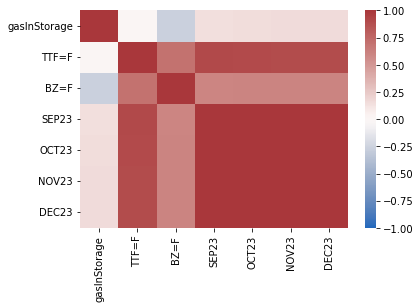

In [18]:
fin_ = fin[["gasInStorage","TTF=F","BZ=F","SEP23","OCT23","NOV23","DEC23","Date"]]
fin_ = fin_.set_index('Date')
sns.heatmap(fin_.corr(), vmin=-1, vmax=1, cmap='vlag')
print(fin_.corr())